In [1]:
import sys
import random
import numpy as np
import jax
import jax.numpy as jnp

from torchvision.datasets import MNIST
from skimage.transform import resize
import matplotlib.pyplot as plt

/Users/haru4me/Documents/diffusion-models-learning/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [181]:
def preproc_data(data: np.ndarray) -> np.ndarray:
    data = jnp.array(data)
    data = data.astype(float)
    data /= 255
    return jax.image.resize(data, shape=(data.shape[0], 14, 14), method="bicubic", )

In [182]:
training = MNIST(
    root="../data/",
    train=True,
    download=True,
).data.numpy()

test = MNIST(
    root="../data/",
    train=False,
    download=True,
).data.numpy()

training = preproc_data(training)
test = preproc_data(test)

In [400]:
def sampling_real(data: np.ndarray, batch_size: int = 32, shuffle: bool = True) -> jnp.array:
    indexes = np.arange(data.shape[0]).astype(int)
    if shuffle:
        indexes = np.random.permutation(indexes)
    num_batches = data.shape[0] // batch_size
    batches_indexes = indexes[:num_batches * batch_size].reshape(num_batches, batch_size)
    for batch_indexes in batches_indexes:
        yield jnp.array(data[batch_indexes, :, :])

@jax.jit
def sample_steps(data: jnp.array, max_steps: int = 100, rng = None) -> jnp.array:
    if rng == None:
        seed = random.randrange(sys.maxsize)
        rng = jax.random.PRNGKey(seed)
    batch_size = data.shape[0]
    return jax.random.uniform(rng, minval=0, maxval=max_steps, shape=(batch_size, )).round().astype(int)

@jax.jit
def sample_noise(data: jnp.array, batch_size: int = 32, rng = None) -> jnp.array:
    if rng == None:
        seed = random.randrange(sys.maxsize)
        rng = jax.random.PRNGKey(seed)
    return jax.random.normal(rng, shape=data.shape)

def linear_beta_schedule(max_steps: int = 100):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start, beta_end, max_steps)

@jax.jit
def alphas_cum_prod(betas, steps):
    alphas = 1 - betas
    alphas_cum_prod = alphas.cumprod()
    return alphas_cum_prod[steps]

@jax.jit
def noised_data(data: jnp.array, steps: jnp.array, noise: jnp.array) -> jnp.array:

    betas = linear_beta_schedule()
    alphas = alphas_cum_prod(betas, steps)
    alpha = alphas[:, None, None]

    biase = jnp.multiply(data, jnp.sqrt(alphas)[:, None, None])
    variance = jnp.multiply(noise, jnp.sqrt(1 - alphas)[:, None, None])

    return  biase + variance

def plot_samples(samples: jnp.array, n_cols: int = None, n_rows: int = None):
    rows = []
    if n_cols is not None:
        n_rows = samples.shape[0] // n_cols
    elif n_rows is not None:
        n_cols = samples.shape[0] // n_rows
    else:
        raise ValueError("Choose cols or rows")
    for i in range(n_rows):
        start = n_cols * i
        end = n_cols * (i + 1)
        rows.append(jnp.hstack(samples[start:end]))
    grid = jnp.vstack(rows)
    plt.imshow(grid, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

In [382]:
sample_real_train = next(sampling_real(training))
steps = sample_steps(sample_real_train)
noise = sample_noise(sample_real_train)
sample_fake_train = noised_data(sample_real_train, steps, noise)

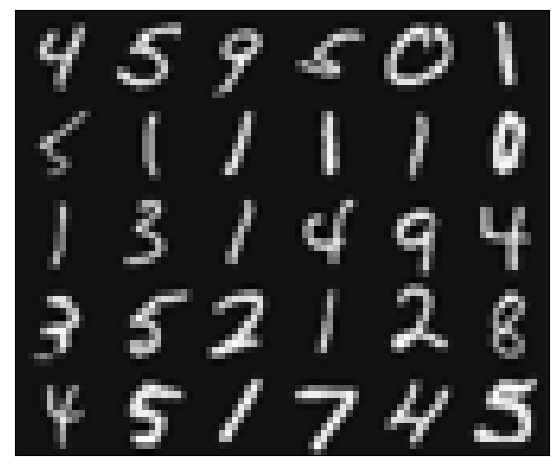

In [383]:
plot_samples(sample_real_train, n_rows=5)

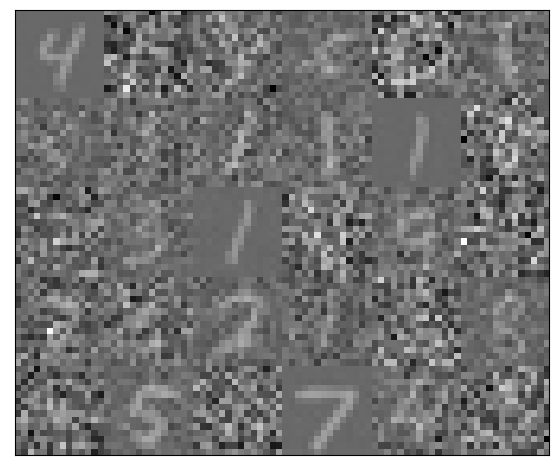

In [384]:
plot_samples(sample_fake_train, n_rows=5)

In [385]:
import flax.linen as nn

In [386]:
class DDPM(nn.Module):

    @nn.compact
    def __call__(self, x, t):

        img_size = x.shape[1:]
        batch_size = list(x.shape)[0]
        x = x.reshape(x.shape[0], -1)
        t = t.reshape(t.shape[0], -1)
        z = jnp.hstack((x, t))

        z = nn.Dense(256)(z)
        z = nn.relu(z)
        z = nn.Dense(512)(z)
        z = nn.relu(z)
        z = nn.Dense(256)(z)
        z = nn.relu(z)
        z = nn.Dense(jnp.prod(np.prod(img_size)))(z)
        z = z.reshape(batch_size, *img_size)

        return z

In [478]:
class StandartConv(nn.Conv):
    eps: float = 1e-5

    def __call__(self, x):
        weight = self.params
        print(weight)
        

In [479]:
rng = jax.random.PRNGKey(0)
StandartConv(64, 3).init(rng, jnp.ones([1, 14, 14]))

AttributeError: "StandartConv" object has no attribute "params".

In [387]:
from functools import partial
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

In [443]:
@struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
  metrics: Metrics

def create_train_state(module, rng, learning_rate):
    params = module.init(rng, jnp.ones([1, 14, 14]), jnp.ones([1, ]))['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(apply_fn=module.apply, params=params, tx=tx, metrics=Metrics.empty())

# @partial(jax.jit, static_argnums=(0,))
def train_step(state, sample, steps, noise):
    def loss_fn(params):
        predicted_noise = state.apply_fn({'params': params}, noised_sample, steps)
        loss = optax.l2_loss(predictions=predicted_noise, targets=noise).mean()
        return loss
    noised_sample = noised_data(sample, steps, noise)
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

# @jax.jit
def validate(state, sample, steps, noise):
    noised_sample = noised_data(sample, steps, noise)
    predicted_noise = state.apply_fn({'params': params}, noised_sample, steps)
    loss = optax.l2_loss(predictions=predicted_noise, targets=noise).mean()
    metric_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state


def sampling(state, noised_sample, max_steps: int = 100):
    steps = jnp.arange(1, max_steps+1).astype('int32').reshape(-1, 1)
    steps = jnp.repeat(steps, noised_sample.shape[0], axis=1)
    betas = linear_beta_schedule(max_steps)
    alphas = 1 - betas
    alphas_overline = alphas_cum_prod(betas, steps[:, 0])

    C1 = 1 / jnp.sqrt(alphas)
    C2 = (1 - alphas) / jnp.sqrt(1 - alphas_overline)
    for i, t in enumerate(steps):
        if i > 0:
            z = sample_noise(noised_sample) 
        else:
            z = jnp.zeros_like(noised_sample)
        predicted_noise = state.apply_fn({'params': params}, noised_sample, t)
        noised_sample = C1[i] * (noised_sample - C2[i] * predicted_noise) + z * betas[i]
    
    return noised_sample

In [463]:
def experiment(model: nn.Module, data: jnp.array, num_epoches: int = 10, batch_size: int = 256, max_steps: int = 100, lr: float = 0.01):
    rng = jax.random.PRNGKey(0)
    state = create_train_state(model, rng, lr)
    loss_history = []

    for epoch in range(num_epoches):

        for real_data in sampling_real(data, batch_size):

            steps = sample_steps(real_data, max_steps, rng)
            noise = sample_noise(real_data, max_steps, rng)

            state = train_step(state, real_data, steps, noise)
            state = validate(state, real_data, steps, noise)

        loss_history.append(float(state.metrics.compute().get('loss')))
        print(f"Loss: %.4f" % loss_history[-1])

    val_noise = sample_noise(real_data, max_steps, rng)[:20]
    generated = sampling(state, val_noise, max_steps)

    return state, loss_history, generated

In [464]:
model = DDPM()
state, loss, samples = experiment(model, training)

Loss: 1.4698
Loss: 1.4697
Loss: 1.4698
Loss: 1.4697
Loss: 1.4697
Loss: 1.4697
Loss: 1.4697
Loss: 1.4697
Loss: 1.4697
Loss: 1.4697


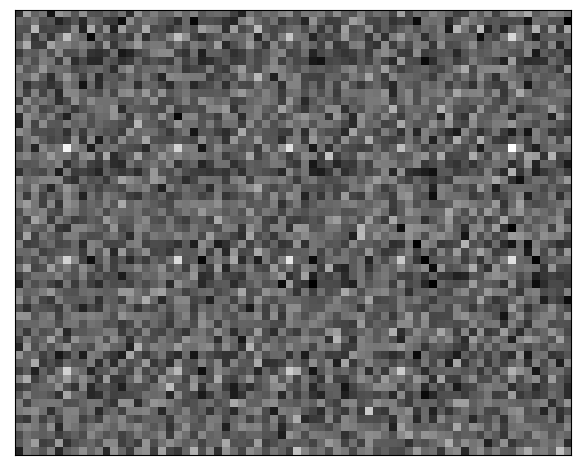

In [465]:
plot_samples(samples, n_cols=5)